In [2]:
# доп. задание: вместо relu в промежуточном слое использовать функцию активации tanh 
import tensorflow as tf
from tensorflow import keras
import numpy as np
print(tf.__version__)

2023-06-12 21:40:59.826657: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 21:41:01.554590: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 21:41:01.557132: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 21:41:08.081503: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0


In [3]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [4]:
# Назначим словарь, который будет отображать слова из массива данных
word_index = imdb.get_word_index()

# Зарезервируем первые несколько значений
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
# Вместо редких слов, не вошедших в набор из 10000, будет указано UNK
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [5]:
# Подготовка данных
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
value=word_index["<PAD>"],
padding='post',
maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data, value=word_index["<PAD>"],
padding='post',
maxlen=256)

In [6]:
# Создание модели
# Размер входных данных - количество слов, использованных в обзорах фильмов (10000 слов)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16, input_shape=(None,)))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.tanh))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Определение функций потерь и оптимизатора
model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['accuracy'])


In [8]:
# Создание проверочного набора данных
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [9]:
# Обучение модели
history = model.fit(partial_x_train,
partial_y_train,
epochs=40,
batch_size=512,
validation_data=(x_val, y_val),
verbose=1)

2023-06-12 21:41:23.379289: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15360000 exceeds 10% of free system memory.


Epoch 1/40
30/30 [==============================] - 4s 54ms/step - loss: 0.6910 - accuracy: 0.5499 - val_loss: 0.6881 - val_accuracy: 0.6168
Epoch 2/40
30/30 [==============================] - 1s 39ms/step - loss: 0.6819 - accuracy: 0.6876 - val_loss: 0.6754 - val_accuracy: 0.7225
Epoch 3/40
30/30 [==============================] - 1s 37ms/step - loss: 0.6624 - accuracy: 0.7398 - val_loss: 0.6517 - val_accuracy: 0.7337
Epoch 4/40
30/30 [==============================] - 1s 36ms/step - loss: 0.6292 - accuracy: 0.7649 - val_loss: 0.6147 - val_accuracy: 0.7612
Epoch 5/40
30/30 [==============================] - 1s 39ms/step - loss: 0.5843 - accuracy: 0.7855 - val_loss: 0.5708 - val_accuracy: 0.7806
Epoch 6/40
30/30 [==============================] - 1s 33ms/step - loss: 0.5337 - accuracy: 0.8073 - val_loss: 0.5245 - val_accuracy: 0.8006
Epoch 7/40
30/30 [==============================] - 1s 38ms/step - loss: 0.4828 - accuracy: 0.8301 - val_loss: 0.4799 - val_accuracy: 0.8221
Epoch 8/40
30

In [10]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

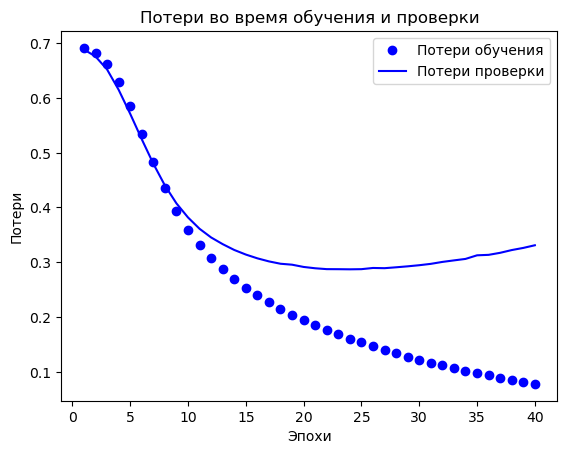

In [11]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" означает "blue dot", синяя точка
plt.plot(epochs, loss, 'bo', label='Потери обучения')
# "b" означает "solid blue line", непрерывная синяя линия
plt.plot(epochs, val_loss, 'b', label='Потери проверки')
plt.title('Потери во время обучения и проверки')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()

plt.show()

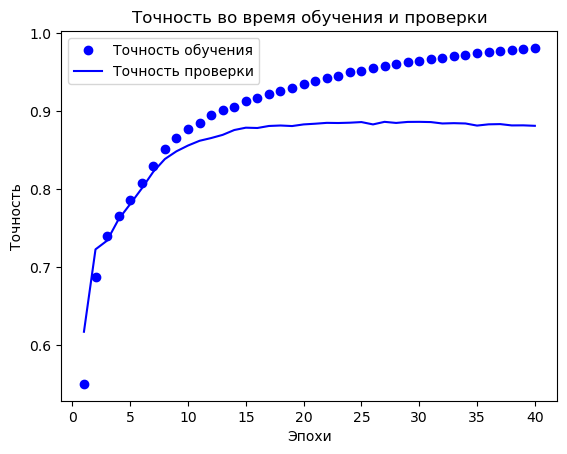

In [12]:
plt.clf() 
# Очистим график

plt.plot(epochs, acc, 'bo', label='Точность обучения')
plt.plot(epochs, val_acc, 'b', label='Точность проверки')
plt.title('Точность во время обучения и проверки')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

In [13]:
# Оценка точности модели
results = model.evaluate(test_data, test_labels)
print(results)

2023-06-12 21:42:51.130512: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25600000 exceeds 10% of free system memory.


782/782 [==============================] - 3s 3ms/step - loss: 0.3539 - accuracy: 0.8688
[0.3539043068885803, 0.8688399791717529]


In [14]:
# Сохранение модели
model.save('model_Dop4_class.h5')
# Создание модели из сохраненного файла
new_model = keras.models.load_model('model_Dop4_class.h5')
# Проверим заданную модель из файла
loss, acc = new_model.evaluate(test_data, test_labels)
print("Восстановленная модель, точность: {:5.2f}%".format(100*acc))

2023-06-12 21:42:54.498246: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25600000 exceeds 10% of free system memory.


782/782 [==============================] - 3s 4ms/step - loss: 0.3539 - accuracy: 0.8688
Восстановленная модель, точность: 86.88%


In [15]:
# Сравним более наглядно точность старой модели относительно новой
loss , acc = model.evaluate(test_data, test_labels)
print("Изначальная модель, точность: {:5.2f}%".format(100*acc))

  1/782 [..............................] - ETA: 46s - loss: 0.3024 - accuracy: 0.8750

2023-06-12 21:42:57.796953: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25600000 exceeds 10% of free system memory.


782/782 [==============================] - 3s 4ms/step - loss: 0.3539 - accuracy: 0.8688
Изначальная модель, точность: 86.88%


In [19]:
baza_model = keras.models.load_model('model_one_class.h5')
loss, acc = baza_model.evaluate(test_data, test_labels)
print("Базовая модель, точность: {:5.2f}%".format(100*acc))
print("Базовая модель, потери: {:5.2f}%".format(100*loss))

Dense3_model =  keras.models.load_model('model_Dop1_class.h5')
test_loss1, test_acc1 = Dense3_model.evaluate(test_data, test_labels)
print("Модель с 3 скрытыми слоями, точность: {:5.2f}%".format(100*test_acc1))
print("Модель с 3 скрытыми слоями, потери: {:5.2f}%".format(100*test_loss1))

Neyron64_model =  keras.models.load_model('model_Dop2_class.h5')
test_loss2, test_acc2 = Neyron64_model.evaluate(test_data, test_labels)
print("Модель с 64 нейронами, точность: {:5.2f}%".format(100*test_acc2))
print("Модель с 64 нейронами, потери: {:5.2f}%".format(100*test_loss2))

Mean_squared_error_model =  keras.models.load_model('model_Dop3_class.h5')
test_loss3, test_acc3 = Mean_squared_error_model.evaluate(test_data, test_labels)
print("Модель с функцией потерь mean_squared_error, точность: {:5.2f}%".format(100*test_acc3))
print("Модель с функцией потерь mean_squared_error, потери: {:5.2f}%".format(100*test_loss3))

Tanh_model =  keras.models.load_model('model_Dop4_class.h5')
test_loss4, test_acc4 = Tanh_model.evaluate(test_data, test_labels)
print("Модель с функцией активации tanh, точность: {:5.2f}%".format(100*test_acc4))
print("Модель с функцией активации tanh, потери: {:5.2f}%".format(100*test_loss4))

train_loss, train_acc = baza_model.evaluate(train_data, train_labels)
train_loss1, train_acc1 = Dense3_model.evaluate(train_data, train_labels)
train_loss2, train_acc2 = Neyron64_model.evaluate(train_data, train_labels)
train_loss3, train_acc3 = Mean_squared_error_model.evaluate(train_data, train_labels)
train_loss4, train_acc4 = Tanh_model.evaluate(train_data, train_labels)

782/782 [==============================] - 6s 7ms/step - loss: 0.3206 - accuracy: 0.8727
Базовая модель, точность: 87.27%
Базовая модель, потери: 32.06%
782/782 [==============================] - 7s 9ms/step - loss: 0.7764 - accuracy: 0.8500
Модель с 3 скрытыми слоями, точность: 85.00%
Модель с 3 скрытыми слоями, потери: 77.64%
782/782 [==============================] - 6s 7ms/step - loss: 0.4244 - accuracy: 0.8627
Модель с 64 нейронами, точность: 86.27%
Модель с 64 нейронами, потери: 42.44%
782/782 [==============================] - 6s 8ms/step - loss: 0.0931 - accuracy: 0.8744
Модель с функцией потерь mean_squared_error, точность: 87.44%
Модель с функцией потерь mean_squared_error, потери:  9.31%
782/782 [==============================] - 5s 6ms/step - loss: 0.3539 - accuracy: 0.8688
Модель с функцией активации tanh, точность: 86.88%
Модель с функцией активации tanh, потери: 35.39%
782/782 [==============================] - 5s 7ms/step - loss: 0.1775 - accuracy: 0.9413


In [20]:
import pandas as pd

Tablica = pd.DataFrame([['Базовая модель',round(100*train_acc, 2), round(100*train_loss, 2), round(100*acc, 2), round(100*loss, 2)],
                   ['Модель с 3 скрытыми слоями', round(100*train_acc1, 2), round(100*train_loss1, 2), round(100*test_acc1, 2), round(100*test_loss1, 2)],
                   ['Модель с 64 нейронами',round(100*train_acc2, 2), round(100*train_loss2, 2), round(100*test_acc2, 2), round(100*test_loss2, 2)],
                   ['Модель с функцией потерь mean_squared_error',round(100*train_acc3, 2), round(100*train_loss3, 2), round(100*test_acc3, 2), round(100*test_loss3, 2)],
                   ['Модель с функцией активации tanh',round(100*train_acc4, 2), round(100*train_loss4, 2), round(100*test_acc4, 2), round(100*test_loss4, 2)]],
                   columns=['Параметры модели','Точность учебного набора', 'Потери учебного набора', 'Точность контрольного набора ', 'Потери контрольного набора'])

Tablica

,Параметры модели,Точность учебного набора,Потери учебного набора,Точность контрольного набора,Потери контрольного набора
0,Базовая модель,93.88,18.05,87.27,32.06
1,Модель с 3 скрытыми слоями,94.50,29.12,85.00,77.64
2,Модель с 64 нейронами,94.66,18.45,86.27,42.44
3,Модель с функцией потерь mean_squared_error,94.00,5.07,87.44,9.31
4,Модель с функцией активации tanh,94.13,17.75,86.88,35.39
